In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

from scipy.stats import shapiro, levene, mannwhitneyu

# 1. Introduction
Facebook is a widely popular social network platform created by Meta. In fact, it is among the greatest players in the digital market, with over 2.96 billion monthly active users for the year 2023. With such a large user base, Facebook has many potential as an effective marketing/advertising channel and is chosen by many digital marketers.

The main business question the project aiming to investigate is the effectiveness (measured by conversion and approved conversion) of three different ad campaigns conducted by an anonymous origanization on Facebook in 2017. To conduct the analysis, I will compare the difference between the three marketing campagin based on analysis of KPIs computed from the data and conduct A/B testing to check if the effect of each marketing campaign is truly due to causality. Additionally, regression analysis will also be included in order to understand the relationship between conversion/approved conversion and the KPIs.

The rest of the project will consider the following main topics:

- Background
- Data preprocessing
- Data analysis
- A/B testing

# 2. Background
The data set is retrieved from the Kaggle data set *Sales Conversion Optimization* by Hakan Kenshin, where it describes the marketing and conversion information of an anonymous organisation’s social media ad campaign.

Overall, the data has 1143 entries and 11 columns. A brief description for each column can be given as follows:

- `ad_id`: an unique ID for each ad.
- `xyz_campaign_id`: an ID associated with each ad campaign of XYZ company.
- `fb_campaign_id`: an ID associated with how Facebook tracks each campaign.
- `age`: age of the person to whom the ad is shown.
- `gender`: gender of the person to whim the add is shown
- `interest`: a code specifying the category to which the person’s interest belongs (interests are as mentioned in the person’s Facebook public profile).
- `Impressions`: the number of times the ad was shown.
- `Clicks`: number of clicks on for that ad.
- `Spent`: Amount paid by company xyz to Facebook, to show that ad.
- `Total_conversion`: Total number of people who enquired about the product after seeing the ad.
- `Approved_conversion`: Total number of people who bought the product after seeing the ad.

# 3. Data preprocessing:

### a. Data cleaning

In [ ]:
df = pd.read_csv('/kaggle/input/clicks-conversion-tracking/KAG_conversion_data.csv')

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ad_id                1143 non-null   int64  
 1   xyz_campaign_id      1143 non-null   int64  
 2   fb_campaign_id       1143 non-null   int64  
 3   age                  1143 non-null   object 
 4   gender               1143 non-null   object 
 5   interest             1143 non-null   int64  
 6   Impressions          1143 non-null   int64  
 7   Clicks               1143 non-null   int64  
 8   Spent                1143 non-null   float64
 9   Total_Conversion     1143 non-null   int64  
 10  Approved_Conversion  1143 non-null   int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 98.4+ KB


,ad_id,xyz_campaign_id,fb_campaign_id,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
count,1.143000e+03,1143.000000,1143.000000,1143.000000,1.143000e+03,1143.000000,1143.000000,1143.000000,1143.000000
mean,9.872611e+05,1067.382327,133783.989501,32.766404,1.867321e+05,33.390201,51.360656,2.855643,0.944007
std,1.939928e+05,121.629393,20500.308622,26.952131,3.127622e+05,56.892438,86.908418,4.483593,1.737708
min,7.087460e+05,916.000000,103916.000000,2.000000,8.700000e+01,0.000000,0.000000,0.000000,0.000000
25%,7.776325e+05,936.000000,115716.000000,16.000000,6.503500e+03,1.000000,1.480000,1.000000,0.000000
50%,1.121185e+06,1178.000000,144549.000000,25.000000,5.150900e+04,8.000000,12.370000,1.000000,1.000000
75%,1.121804e+06,1178.000000,144657.500000,31.000000,2.217690e+05,37.500000,60.025000,3.000000,1.000000
max,1.314415e+06,1178.000000,179982.000000,114.000000,3.052003e+06,421.000000,639.949998,60.000000,21.000000


The columns all have no null or invalid type values. Moreover, from observing the quantiles, max and min values, there are no clear sign of outliers presented in the data.

Nonetheless, it is easy to notice that some of entries are errorneous, containing 0 values in `Clicks`, while the other columns such as `Total_Conversion` whave non-zero values. This is illogical because an ad cannot still gain postive conversions (customers) while no one clicks on it.

In [ ]:
print("The number of 0-values in Clicks (given that Conversion are non-zero):", len(df[(df["Clicks"] == 0) & (df["Total_Conversion"] != 0)]))

The number of 0-values in Clicks (given that Conversion are non-zero): 204


To perform imputation for the invalid values in `Clicks`, we can use the K-Nearest Neighbors (KNN) algorithm from `sklearn`. The algorithm will attempt to predict the true value of an entry in reference to the mean of its neighbors, which partially negates the probability of generating biased values.

In [ ]:
df["Clicks"].replace(0, np.nan, inplace=True)

imputer = KNNImputer(n_neighbors=2)
df_imputed = pd.DataFrame(imputer.fit_transform(df.drop(columns=["gender", "age"])))

df["Clicks"] = df_imputed[5]

Within the scope of the project, the columns `ad_id` and `fb_campaign_id` are redundant, because it is enough to categorize advertising campaign using just `xyz_campaign_id`, which are the id of each campaign provided by the company itself. Therefore, the two columns `ad_id` and `fb_campaign_id` will be dropped. This is the same case to `interest`, where it contributes  little information to the analysis. Moreover, given that the categorical column `xyz_campaign_id` is given in numerical form, which can be interpreted as continuous variables by Python, the values within the column will be converted to the categorical `object` type.

In [ ]:
df = df.drop(columns=["ad_id", "fb_campaign_id", "interest"])
df["xyz_campaign_id"] = df["xyz_campaign_id"].astype('object', copy=False)

### b. Additional feature engineering
Using the features given in the data set, we can also perform feature engineering to generate some KPIs that are important for later analysis:

- **Conversion rate (CR)**. The rate of user who enquired the product after viewing the ad. This helps to measure the the percentage of users that actually become interested and bought the product being motivated by viewing the ad in a marketing campaign.
- **Click-through rate (CTR)**. The ratio of clicks from impressions of each ad. In other words, CTR is the percentage of users that click on the ad among those who have seen the ad. This metric measures how engaging and relevant are the ads to the targetted audience.
- **Cost per click (CPC)**. The cost of gaining a click in each ad. This metric can help evaluate whether the spending on aquiring one additional user to pay attention to the ad is cost-efficient or not.

In [ ]:
df["CR"] = df["Total_Conversion"] / df["Impressions"]
df["CTR"] = df["Clicks"] / df["Impressions"]
df["CPC"] = df["Spent"] / df["Clicks"]

# 4. Data analysis

## a. Exploratory analysis
Before going in the details of the efficiency of each ad campaign, let us familiarize ourselves with the data by performing exploratory analysis of the features firstly (for the sake of simplicity, we will not pay attention to the newly added columns (`CPC`, `CR` and `CTR`), since they are computed directly from the given original columns). The histogram for each feature can be given by:

(0.0, 1.0, 0.0, 1.0)

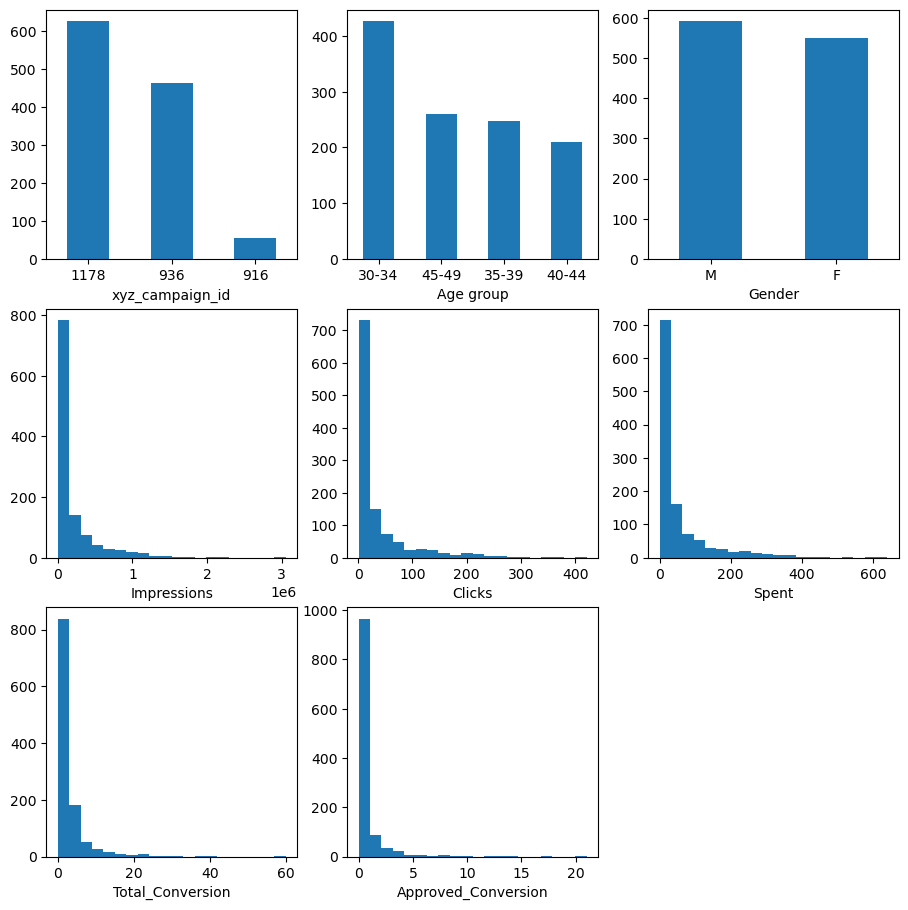

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(11,11))
df["xyz_campaign_id"].value_counts().plot(kind="bar", ax=ax[0, 0])
ax[0, 0].tick_params(labelrotation=0)
ax[0, 0].set_xlabel("xyz_campaign_id")

df["age"].value_counts().plot(kind="bar", ax=ax[0, 1])
ax[0, 1].tick_params(labelrotation=0)
ax[0, 1].set_xlabel("Age group")


df["gender"].value_counts().plot(kind="bar", ax=ax[0, 2])
ax[0, 2].tick_params(labelrotation=0)
ax[0, 2].set_xlabel("Gender")

df["Impressions"].hist(ax=ax[1, 0], bins=20)
ax[1, 0].grid(False)
ax[1, 0].set_xlabel("Impressions")

df["Clicks"].hist(ax=ax[1, 1], bins=20)
ax[1, 1].grid(False)
ax[1, 1].set_xlabel("Clicks")

df["Spent"].hist(ax=ax[1, 2], bins=20)
ax[1, 2].grid(False)
ax[1, 2].set_xlabel("Spent")

df["Total_Conversion"].hist(ax=ax[2, 0], bins=20)
ax[2, 0].grid(False)
ax[2, 0].set_xlabel("Total_Conversion")

df["Approved_Conversion"].hist(ax=ax[2, 1], bins=20)
ax[2, 1].grid(False)
ax[2, 1].set_xlabel("Approved_Conversion")

ax[2, 2].axis('off')

From the trellis, we can make some quick observations:

- The campaign id 1178 and 936 are relatively more focused on by the company than 916. This is given by the number of times the ad campaigns appear, where 1178 and 936 shows up more than 400 times, while it is less than 100 times for 916.  
- The most focused age group is 30-34, where the number of audience in that age group is roughly 1.5 times of other groups.
- The number of male and female users are roughly equal.
- The distribution of Impressions, Clicks, Spent, Total_Conversion and Approved_Conversion are significantly alike. One possible explanation for this is that the variables are strongly dependent, i.e. the higher the spending, the higher the impressions, clicks and thus the higher the conversion rate of users.

In addition, we would also want to inveestigate the correlation between the features, which can help verify our explanation for the almost same distributions of some variables. This is because having same distribution does not necessarily imply that the variables are highly correlated.

<AxesSubplot:>

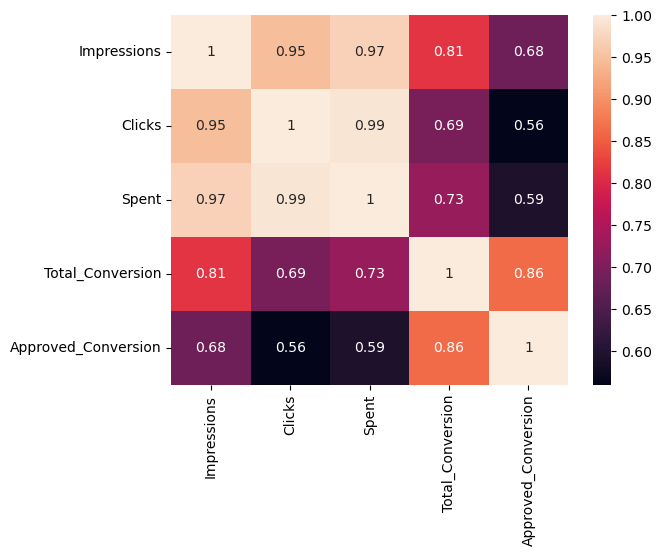

In [ ]:
sns.heatmap(df.drop(columns=["CR", "CPC", "CTR"]).corr(), annot=True)

As expected, multicollinearity is presented within `Impressions`, `Clicks` and `Spent`, showing almost perfect linear dependence relationship. For the other features, the correlation coefficient is not as significant but is also relatively high, ranging from around 0.56 to 0.86.

## b. Campaign analysis
First, we may plot the three ad campaign id on the same graph for each other variables for an overall overview and comparison of the campaigns' performance. Note that for non-categorical (numerical) features, the values are aggregated into sums for each campaign.

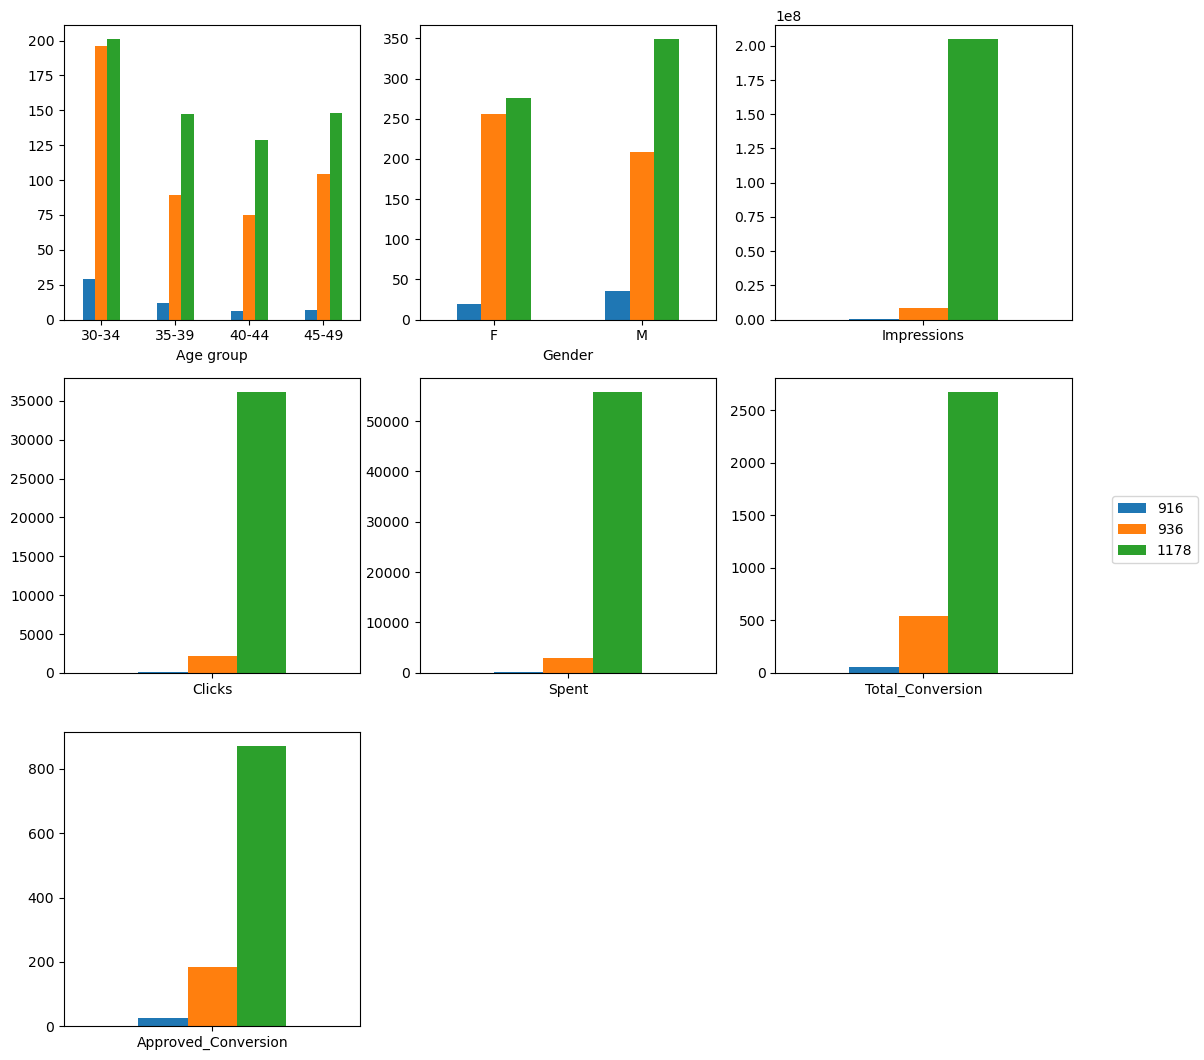

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(13,13))
df[["age", "xyz_campaign_id"]].pivot_table(index="age", columns="xyz_campaign_id", aggfunc=len, fill_value=0).plot(kind="bar", ax=ax[0, 0], legend=None)
ax[0, 0].tick_params(labelrotation=0)
ax[0, 0].set_xlabel("Age group")

df[["gender", "xyz_campaign_id"]].pivot_table(index="gender", columns="xyz_campaign_id", aggfunc=len, fill_value=0).plot(kind="bar", ax=ax[0, 1], legend=None)
ax[0, 1].tick_params(labelrotation=0)
ax[0, 1].set_xlabel("Gender")

df[["xyz_campaign_id", "Impressions"]].pivot_table(columns="xyz_campaign_id", values="Impressions", aggfunc=sum).plot(kind="bar", ax=ax[0, 2], legend=None)
ax[0, 2].tick_params(labelrotation=0)

df[["xyz_campaign_id", "Clicks"]].pivot_table(columns="xyz_campaign_id", values="Clicks", aggfunc=sum).plot(kind="bar", ax=ax[1, 0], legend=None)
ax[1, 0].tick_params(labelrotation=0)

df[["xyz_campaign_id", "Spent"]].pivot_table(columns="xyz_campaign_id", values="Spent", aggfunc=sum).plot(kind="bar", ax=ax[1, 1], legend=None)
ax[1, 1].tick_params(labelrotation=0)

df[["xyz_campaign_id", "Total_Conversion"]].pivot_table(columns="xyz_campaign_id", values="Total_Conversion", aggfunc=sum).plot(kind="bar", ax=ax[1, 2], legend=None)
ax[1, 2].tick_params(labelrotation=0)

df[["xyz_campaign_id", "Approved_Conversion"]].pivot_table(columns="xyz_campaign_id", values="Approved_Conversion", aggfunc=sum).plot(kind="bar", ax=ax[2, 0], legend=None)
ax[2, 0].tick_params(labelrotation=0)

ax[2, 1].axis('off')
ax[2, 2].axis('off')

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right')


Based on the bar plots, we can make some general observations:

- All three campaigns primarily target the 30-34 age group. Campaign 936 has a mostly female audience, while the other two campaigns have more male audiences.
- Campaign 1178 dominates the other two campaigns in terms of investment (spent), impressions, clicks and conversion. This is expected, as we earlier has show that these variables are strongly dependent on each other: with higher campaign budget comes higher audience reach and thus higher clicks and conversion.

It is clear to recognize that campaign 1178 outperforms its counterparts by showing noteably higher interactions and conversion. However, as we recall, this is a highly possible result of the significantly larger spending allocated for campaign 1178 by the company (over 45000 USD than 936, and over 50000 USD than 916); and we cannot know whether the other campaigns would obtain the same, or even better results if they were invested the same amount. Therefore, it would not be reasonable to rush to the conclusion that 1178 has  better efficiency.

# 5. A/B testing
In order to gain a better assessment of the campaigns' true performance, we must look into the KPIs `CR`, `CPC` and `CTR` chosen above. To briefly describe, `CR` (conversion rate) reflects the conversion ability for each campaign, `CPC` (cost per click) measures the cost efficiency for each click the ad set recieve, and `CTR` (click through rate) shows the ability to attract and engage customers. Because the three metrics are measured as ratio, they can allow more robust and more accurate comparison between ad campaigns even with large differences in spending.

Let us visualize the means of the KPIs for all the ad sets belong from each of the three ad campaigns:

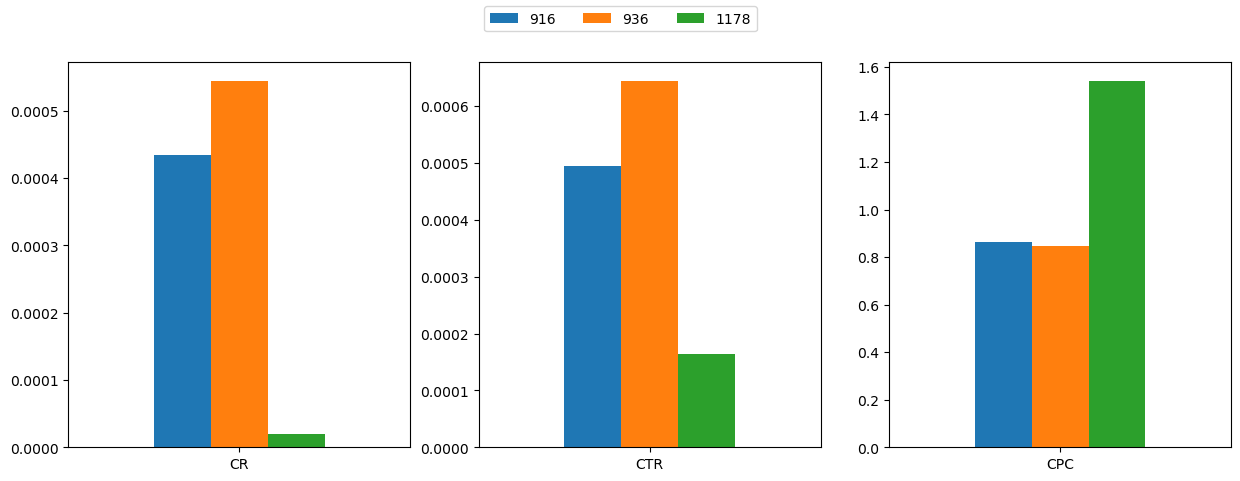

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

df[["xyz_campaign_id", "CR"]].pivot_table(columns="xyz_campaign_id", values="CR", aggfunc=np.mean).plot(kind="bar", ax=ax[0], legend=None)
ax[0].tick_params(labelrotation=0)

df[["xyz_campaign_id", "CTR"]].pivot_table(columns="xyz_campaign_id", values="CTR", aggfunc=np.mean).plot(kind="bar", ax=ax[1], legend=None)
ax[1].tick_params(labelrotation=0)

df[["xyz_campaign_id", "CPC"]].pivot_table(columns="xyz_campaign_id", values="CPC", aggfunc=np.mean).plot(kind="bar", ax=ax[2], legend=None)
ax[2].tick_params(labelrotation=0)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)

Based on the charts, we can see that mean CR and CTR is the highest for campaign 936, second highest for 916 and surprisingly, lowest for 1178. Meanwhile, mean CPC is again the highest for 1178. From the KPIs, campaign 1178 is not at all cost-efficient with highest CPC, while generate much lower CR and CTR than its counterparts. On the other hand, 936 and 916 has proven to perform better in terms of conversion, engagement and cost-efficiency, with higher CTR, CR while remain lower in CPC. In the previous analysis, though we have observed significant greater number of clicks, impressions and conversions from 1178, it is now clear that seems to be explained by the higher allocated budget.

In order to verify whether the differences between ad campaigns are statistically significant or due to chance, we can perform A/B testing. The main of A/B testing for three groups is to make pairwise comparisons between each pair of groups A-B, A-C and B-C, therefore asserting whether the differences between them are statisticsally significant or not.

### Residuals normality check:

Null hypothesis: The distribution of the sample are close to normal.

Alternate hypothesis: The distribution of the sample are not close to normal.

- For Conversion rate:

In [ ]:
_, pvalue1 = shapiro(df.loc[df["xyz_campaign_id"] == 916, "CR"])
_, pvalue2 = shapiro(df.loc[df["xyz_campaign_id"] == 936, "CR"])
_, pvalue3 = shapiro(df.loc[df["xyz_campaign_id"] == 1178, "CR"])

print("p-value for group A: ", pvalue1)
print("p-value for group B: ", pvalue2)
print("p-value for group C: ", pvalue3)

p-value for group A:  5.963339266834566e-10
p-value for group B:  4.1502109160952264e-34
p-value for group C:  1.2178807485675199e-33


Because all three groups yield p-values much lower than 0.05, there is strong evidence against the Null hypothesis, and the groups' residuals are not normal.  

- For Click through rate:

In [ ]:
_, pvalue1 = shapiro(df.loc[df["xyz_campaign_id"] == 916, "CTR"])
_, pvalue2 = shapiro(df.loc[df["xyz_campaign_id"] == 936, "CTR"])
_, pvalue3 = shapiro(df.loc[df["xyz_campaign_id"] == 1178, "CTR"])

print("p-value for group A: ", pvalue1)
print("p-value for group B: ", pvalue2)
print("p-value for group C: ", pvalue3)

p-value for group A:  8.429493214556771e-11
p-value for group B:  5.090885117483896e-34
p-value for group C:  1.2266385965631343e-05


Because all three groups yield p-values much lower than 0.05, there is strong evidence against the Null hypothesis, and the groups' residuals are not normal.

In [ ]:
_, pvalue1 = shapiro(df.loc[df["xyz_campaign_id"] == 916, "CPC"])
_, pvalue2 = shapiro(df.loc[df["xyz_campaign_id"] == 936, "CPC"])
_, pvalue3 = shapiro(df.loc[df["xyz_campaign_id"] == 1178, "CPC"])

print("p-value for group A: ", pvalue1)
print("p-value for group B: ", pvalue2)
print("p-value for group C: ", pvalue3)

p-value for group A:  7.768696974608247e-08
p-value for group B:  2.5886480465588818e-24
p-value for group C:  1.3052785662067448e-31


Because all three groups yield p-values much lower than 0.05, there is strong evidence against the Null hypothesis, and the groups' residuals are not normal.

Since all three groups of all three KPIs fail to satisfy the normality condition, we can use the non-parametric Mann Whitney U test.

### Mann Whitney U test:

Null hypothesis: There is no difference (in terms of central tendency) between the two groups in the population

Alternate hypothesis: There is a difference (with respect to the central tendency) between the two groups in the population.

- For Conversion rate:

In [ ]:
_, pvalue1 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 916, "CR"], df.loc[df["xyz_campaign_id"] == 936, "CR"])
_, pvalue2 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 936, "CR"], df.loc[df["xyz_campaign_id"] == 1178, "CR"])
_, pvalue3 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 1178, "CR"], df.loc[df["xyz_campaign_id"] == 916, "CR"])

print("p-value for 916-936: ", pvalue1)
print("p-value for 936-1178: ", pvalue2)
print("p-value for 1178-916: ", pvalue3)

p-value for 916-936:  0.4339652264015792
p-value for 936-1178:  1.7577705732449588e-133
p-value for 1178-916:  6.636971249222305e-31


- For Click through rate:

In [ ]:
_, pvalue1 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 916, "CTR"], df.loc[df["xyz_campaign_id"] == 936, "CTR"])
_, pvalue2 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 936, "CTR"], df.loc[df["xyz_campaign_id"] == 1178, "CTR"])
_, pvalue3 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 1178, "CTR"], df.loc[df["xyz_campaign_id"] == 916, "CTR"])

print("p-value for 916-936: ", pvalue1)
print("p-value for 936-1178: ", pvalue2)
print("p-value for 1178-916: ", pvalue3)

p-value for 916-936:  0.953272496172231
p-value for 936-1178:  5.773236981710117e-95
p-value for 1178-916:  8.021835868757632e-20


- For Cost per click:

In [ ]:
_, pvalue1 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 916, "CPC"], df.loc[df["xyz_campaign_id"] == 936, "CPC"])
_, pvalue2 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 936, "CPC"], df.loc[df["xyz_campaign_id"] == 1178, "CPC"])
_, pvalue3 = mannwhitneyu(df.loc[df["xyz_campaign_id"] == 1178, "CPC"], df.loc[df["xyz_campaign_id"] == 916, "CPC"])

print("p-value for 916-936: ", pvalue1)
print("p-value for 936-1178: ", pvalue2)
print("p-value for 1178-916: ", pvalue3)

p-value for 916-936:  0.7970274733773802
p-value for 936-1178:  3.206787240273559e-76
p-value for 1178-916:  1.9701792542537628e-18


In all three cases, compared to the adjusted significance level 0.01667, we do not reject the Null hypohesis for 916-936, but reject for 936-1178 and 1178-916. This suggests that the difference in CR, CTR and CPC between 936-1178 and 1178-916 is statistically significant and should be considered, while the difference of the KPIs between 916-936 is only due to chance.

For the company, this means that any (spending) changes to ad campaign 916 and 936 would not result in a more significant impacts on the conversion rate, engagement (CTR) and cost per click over the other. In other words, their relative performance (in terms of the defined KPIs) are the same. On the other hand, we are able to detect significant differences between 936 and 916 to 1178, which shows that with relative to their spending, the two campaigns have performed significantly better, in terms of conversion, engagement and cost-efficincy than 1178, which was allocated a much higher investment.



Based on the results of A/B testing and campaign analysis, we can come up with some actionable approach:

- With much higher performance in terms of conversion rate and click through rate found in ad campaign 916 and 936, the company should prioritize scaling them up. This should, obviously, be taken with caution, as we cannot know precisely how the campaigns would change reaching a larger number of audiences.
- Given a great budget, 1178 was able to generate large conversions and impressions. However, it efficiency is far lower than what the other two campaigns can generate with a lower budget. The company should investigate the reason for the lack of engagement and conversions of 1178, especially given that it is exposed to a much larger audience reach.
- The most interested audiences are from the age group 30-34. The company should target this age group for highest user engagement and interactions. On the other hand, other existing age groups should also be investigated to understand the reason for lower interactions with ad.

